In [814]:
import os
import sys
%cd /app/build

/app/build


<h2 style="text-align:center;font-size:200%;;">Exploratory Data Analysis </h2>

In [1]:
import os
import time
import warnings

In [15]:
class CONFIG:
    NUM_WORKERS = os.cpu_count()
    SEED = 24
    TARGET = 'Retained'
    
    TARGET_ENCODED = 'target'
    NUM_FOLDS = 5
    
    # Define data directory paths
    DATASET_PATH = 'data/'

    # Define .json/schema path
    DATA_JSON = 'data/FitRec-Dataset_bigdata/endomondoHR.json' 
    SCHEMA_JSON = 'config/schema_json.yaml'
    
    # Define .csv/schema path
    DATA_CSV = 'data/RetentionData.csv'
   

In [18]:
import pandas as pd
df = pd.read_csv(CONFIG.DATA_CSV)


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 746 entries, 0 to 745
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   AdmitTerm       746 non-null    object 
 1   School          746 non-null    object 
 2   Program         746 non-null    object 
 3   NationalStatus  746 non-null    object 
 4   Enrolled        746 non-null    int64  
 5   Retained        746 non-null    float64
dtypes: float64(1), int64(1), object(4)
memory usage: 35.1+ KB


# **1. Initialization and load data** <a class="anchor" id="1"></a>


In [25]:
# %%capture
# !pip install seaborn optuna xgboost  lightgbm tabulate 
!pip install pyspark;
# !pip install  stickyland
!pip install ensure

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 12.2 MB/s eta 0:00:00m eta 0:00:010:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840633 sha256=ca0ba5ee24d53160e4b9f03e217e634d435f7eff7fe0918d4cf6805c3f9e162e
  Stored in directory: /home/abdo2020/.cache/pip/wheels/94/3e/42/5eee4ed6246b61022f0335dcf22bb1a4a3915c45c0135cdc6f
Successfully built pyspark


In [22]:
# Import other modules not related to PySpark
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interTarget = "all" 
%matplotlib inline

### Setup & initializations:
import the needed packages 

In [26]:
# Import PySpark related modules
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct
from pyspark.sql.types import *
import pyspark.sql.functions as F

MAX_MEMORY = '4G'
# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("NAIT challenge") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()

/opt/spark/bin/spark-class: line 71: /usr/lib/jvm/java-11-openjdk-amd64/bin/java: No such file or directory
/opt/spark/bin/spark-class: line 96: CMD: bad array subscript


PySparkRuntimeError: [JAVA_GATEWAY_EXITED] Java gateway process exited before sending its port number.

### Load the dataset
load the data into spark dataframe

In [676]:
def read_file_pyspark(file_path, schema=None):
    # Load the main data set into pyspark data frame 
    if os.path.splitext(file_path)[1]=='.csv':
        df = spark.read.option("header", True).csv(file_path, schema=schema)
    elif os.path.splitext(filename)[1]=='.json' :  
        df = spark.read.json(file_path, mode="DROPMALFORMED")
        
    return df

In [677]:
###### Load & view the dataset
file_path = CONFIG.DATA_CSV # CONFIG.DATA_JSON
df = read_file_pyspark(file_path, schema=SchemaStruct)
print('Data frame type: ' + str(type(df)))

Data frame type: <class 'pyspark.sql.dataframe.DataFrame'>


In [678]:
###### Load & view the dataset
file_path = CONFIG.DATA_CSV # CONFIG.DATA_JSON
df = read_file_pyspark(file_path, schema=SchemaStruct)
print('Data frame type: ' + str(type(df)))

Data frame type: <class 'pyspark.sql.dataframe.DataFrame'>


# **2. Overview of Dataset** <a class="anchor" id="2"></a>

<!-- [Go back to table of contents](#0.1) -->

### Schema, columns & datatypes of the data set:

In [679]:
# Explore some columns  
df.printSchema()
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type']).T

root
 |-- x1: float (nullable = true)
 |-- x2: float (nullable = true)
 |-- x3: float (nullable = true)
 |-- x4: string (nullable = true)
 |-- x5: float (nullable = true)
 |-- x6: float (nullable = true)
 |-- x7: float (nullable = true)
 |-- x8: float (nullable = true)
 |-- y: string (nullable = true)



,0,1,2,3,4,5,6,7,8
Column Name,x1,x2,x3,x4,x5,x6,x7,x8,y
Data type,float,float,float,string,float,float,float,float,string


In [680]:
print(f'\n Dataset size = {(df.count(), len(df.columns))}: ')
df.orderBy(F.rand()).limit(5).toPandas()

print(f'\n Dataset stats : ')

df.describe().toPandas()


 Dataset size = (570, 9): 


,x1,x2,x3,x4,x5,x6,x7,x8,y
0,0.276,0.273,0.192,w,0.871,0.285,0.186,0.9018,0.5
1,0.240,0.293,0.228,s,0.966,0.323,0.227,0.3557,0.25
2,0.322,0.353,0.270,w,0.906,0.341,0.214,0.8846,1
3,0.314,0.333,0.583,g,0.642,0.419,0.510,0.8292,0.25
4,0.454,0.404,0.312,a,0.905,0.478,0.285,0.9308,0.125



 Dataset stats : 


,summary,x1,x2,x3,x4,x5,x6,x7,x8,y
0,count,569,568,569,570,569,569,567,570,569
1,mean,NaN,0.3304894365711321,0.2533813705291396,None,0.8429666087162306,0.35556414690660887,0.23819752933697305,0.55148227967714,0.37831858407079644
2,stddev,NaN,0.0712959151125506,0.0795033026771436,None,0.15165961150497156,0.07945653854633015,0.08201197724172747,0.2515110532973891,0.3672591183706136
3,min,0.071,0.059,0.056,a,0.256,0.106,0.058,0.1013,0
4,max,NaN,1.0,1.0,y,1.0,1.0,1.0,0.9953,o


# **3. Data Preprocessing** <a class="anchor" id="3"></a>


## Check missing/invalid values

[Go back to table of contents](#0.1)

After having a first sight of the columns, the first thing we should check is if the data set having any missing value.
- For string columns, we check for `None` and `null`
- For numeric columns, we check for zeroes and `NaN`
- For array type columns, we check if the array contain zeroes or `NaN`

In [681]:
def group_data_coloumns(df, target):
    numeric_columns = [item[0] for item in df.dtypes if not item[1].startswith('string') and not item[1].startswith('array')]
    string_columns = [item[0] for item in df.dtypes if item[1].startswith('string')]# - [CONFIG.TARGET]
    array_columns = [item[0] for item in df.dtypes if item[1].startswith('array')]
    
    return numeric_columns, string_columns, array_columns

numeric_columns, string_columns, array_columns = group_data_coloumns(df, target=CONFIG.TARGET)


In [682]:
missing_values = {} 
for index, column in enumerate(df.columns):
    if column in string_columns:    # check string columns with None and Null values
#         missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
#         missing_values.update({column: missing_count})
        missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
        missing_values.update({column:missing_count})
    if column in numeric_columns:  # check zeroes, None, NaN
        missing_count = df.where(col(column).isin([0,None,np.nan])).count()
        missing_values.update({column:missing_count})
    if column in array_columns:  # check zeros and NaN
        missing_count = df.filter(array_contains(df[column], 0) | array_contains(df[column], np.nan)).count()
        missing_values.update({column:missing_count})
missing_df = pd.DataFrame.from_dict([missing_values])
missing_df

24/09/24 20:16:04 ERROR CodeGenerator: failed to compile: org.codehaus.commons.compiler.CompileException: File 'generated.java', Line 39, Column 67: No applicable constructor/method found for actual parameters "java.lang.Object"; candidates are: "public static boolean java.lang.Float.isNaN(float)", "public boolean java.lang.Float.isNaN()"
org.codehaus.commons.compiler.CompileException: File 'generated.java', Line 39, Column 67: No applicable constructor/method found for actual parameters "java.lang.Object"; candidates are: "public static boolean java.lang.Float.isNaN(float)", "public boolean java.lang.Float.isNaN()"
	at org.codehaus.janino.UnitCompiler.compileError(UnitCompiler.java:13014)
	at org.codehaus.janino.UnitCompiler.findMostSpecificIInvocable(UnitCompiler.java:9615)
	at org.codehaus.janino.UnitCompiler.findIMethod(UnitCompiler.java:9475)
	at org.codehaus.janino.UnitCompiler.findIMethod(UnitCompiler.java:9391)
	at org.codehaus.janino.UnitCompiler.compileGet2(UnitCompiler.java:

,x1,x2,x3,x4,x5,x6,x7,x8,y
0,1,0,0,0,0,0,0,0,1


In [683]:
missing_df

,x1,x2,x3,x4,x5,x6,x7,x8,y
0,1,0,0,0,0,0,0,0,1


### Remove duplicates samples

In [832]:
# remove duplicates samples
df = df.dropDuplicates()

### Drop rows missing/invalid values

In [684]:
from ensure import ensure_annotations
@ensure_annotations
def count_missings(df, sort:bool=True) ->pd.DataFrame:
    """
    Counts number missing/invalid values
    """
    # convert pandas datarame to spark 
    if isinstance(df, pd.DataFrame):
        from pyspark.sql import SparkSession
        spark = SparkSession.builder.appName("pandas to spark").getOrCreate()
        # conversion
        # Creating the DataFrame
        df = spark.createDataFrame(df)

        
    df = df.select([F.count(F.when( F.isnan(F.col(each_col)) | \
                                    (F.col(each_col) == "") | \
                                    (F.col(each_col) == "NaN") | \
                                    (F.col(each_col) == "nan") | \
                                    F.isnull(F.col(each_col)) | \
                                    (F.lower(F.col(each_col)) == "null") \
                                   , 1)).alias(f"{each_col}") for each_col in df.columns]).toPandas()
    # check if any mising/invalid values is found 
    if len(df) == 0:
        print("There are no any missing values!")
        return pd.DataFrame()

    # if sort:
    #     return df.rename(index={0: 'count'}).T.sort_values("count",ascending=False)

    return df.rename(index={0: 'missing/invalid count'})

# View dataset missing/invlid values count
print(f'\n- [raw dataset](size = {(df.count(), len(df.columns))}): The initial missing/invlid values count: ')
df_count_missings = count_missings(df)
df_count_missings

def processing_pipeline(df, drop_na=True):
    if drop_na:
        df = df.na.drop()
    return df

# apply the pre-processing pipeline
df = processing_pipeline(df, drop_na=True)

# View dataset missing/invlid values count
print(f'\n- [cleaned dataset1](size = {(df.count(), len(df.columns))}): The missing/invlid values count: ')
df_count_missings = count_missings(df)
df_count_missings


- [raw dataset](size = (570, 9)): The initial missing/invlid values count: 


,x1,x2,x3,x4,x5,x6,x7,x8,y
missing/invalid count,2,2,1,0,1,1,3,0,1



- [cleaned dataset](size = (559, 9)): The missing/invlid values count: 


,x1,x2,x3,x4,x5,x6,x7,x8,y
missing/invalid count,0,0,0,0,0,0,0,0,0


## Rename columns

In [685]:
df = df.withColumnRenamed("y", "target")
df.limit(5).toPandas()

,x1,x2,x3,x4,x5,x6,x7,x8,target
0,0.248,0.253,0.173,o,0.877,0.309,0.160,0.4463,1
1,0.302,0.351,0.213,y,0.902,0.296,0.196,0.3941,1
2,0.300,0.344,0.260,a,0.863,0.331,0.223,0.4010,1
3,0.326,0.362,0.237,e,0.894,0.325,0.209,0.5909,1
4,0.270,0.320,0.232,g,0.903,0.323,0.195,0.7388,1


## Augment/add new columns/attributs/variables

In [686]:
# We will create a new column defing a new equation
df = df.withColumn('log(x1) + sin(x2+x5)', F.log(df['x1']) / F.sin(df['x2'] + df['x5']))
df.limit(5).toPandas()

,x1,x2,x3,x4,x5,x6,x7,x8,target,log(x1) + sin(x2+x5)
0,0.248,0.253,0.173,o,0.877,0.309,0.160,0.4463,1,-1.541694
1,0.302,0.351,0.213,y,0.902,0.296,0.196,0.3941,1,-1.260443
2,0.300,0.344,0.260,a,0.863,0.331,0.223,0.4010,1,-1.288288
3,0.326,0.362,0.237,e,0.894,0.325,0.209,0.5909,1,-1.178784
4,0.270,0.320,0.232,g,0.903,0.323,0.195,0.7388,1,-1.392721


 As we can see, The total records for this dataset is over 111M records. It's really large size

# **4. Pyspark lazy evaluation** <a class="anchor" id="4"></a>

[Go back to table of contents](#0.1)

Here we will begin to be familiar with some of Advanced Spark feature: **Lazy evaluation**.

<font color="red"><b>Lazy evaluation</b></font> enhances the power of Apache Spark by reducing the execution time of the RDD operations. It maintains the lineage graph to remember the operations on RDD. we can simply remember that all processing in Pyspark is abstraction, When we want to return the results, actually we tell Spark what is the eventual answer you're interested and it figures out best way to get there. As a result, it optimizes the performance and achieves fault tolerance. 

In order to see the result, we have to call Spark.collect(). 

Normolly, we can show the results with the syntax: df.take(k) or df.limit(k) to get the results with k row. 

When K become large number, These 2 way above takes a long time to complete the process. Because this syntax above did not utilize the power of Pyspark processing (Lazy evaluation).
In order to quickly processing , We should use df.collect()[:k] to return the k row as we want.

You can read more about Pyspark lazy evaluation in : https://data-flair.training/blogs/apache-spark-lazy-evaluation/

In [848]:
def variable_distribution(x:np.array, y:np.array):
    #compute the percentage
    percentage = y/y.sum() * 100
    nb_labels = len(np.unique(x))    
    # plot the canvas
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(0.35))
    plot0 =   axs[0].bar(x=x, height=y)
    axs[0].set_xlabel('Target', fontsize = 'small')
    axs[0].set_ylabel('Counts', fontsize = 'small')
    # axs[0].set_xticklabels(x, rotation = 'vertical', fontsize='small')
    
    # Pie chart
    explode = [1/nb_labels for k in range(nb_labels)]
    assert len(x) == len(explode) , print(f' {explode} does not fit the variable {x}')
    plot1 = axs[1].pie(x=percentage, 
                       labels=x, 
                       autopct='%1.1f%%', 
                       shadow=True, 
                       explode=explode, 
                       startangle=90, 
                       radius=1
    )

In [688]:
ranked_target_by_user = df.select(df.target, df.x4) \
    .distinct() \
    .groupBy(df.target) \
    .count() \
    .orderBy("count", ascending=False)


ranked_target_by_user_df = ranked_target_by_user.toPandas()

In [689]:
ranked_target_by_user.collect()[:5]

[Row(target='0.25', count=13),
 Row(target='0', count=13),
 Row(target='0.5', count=13),
 Row(target='1', count=13),
 Row(target='0.125', count=13)]

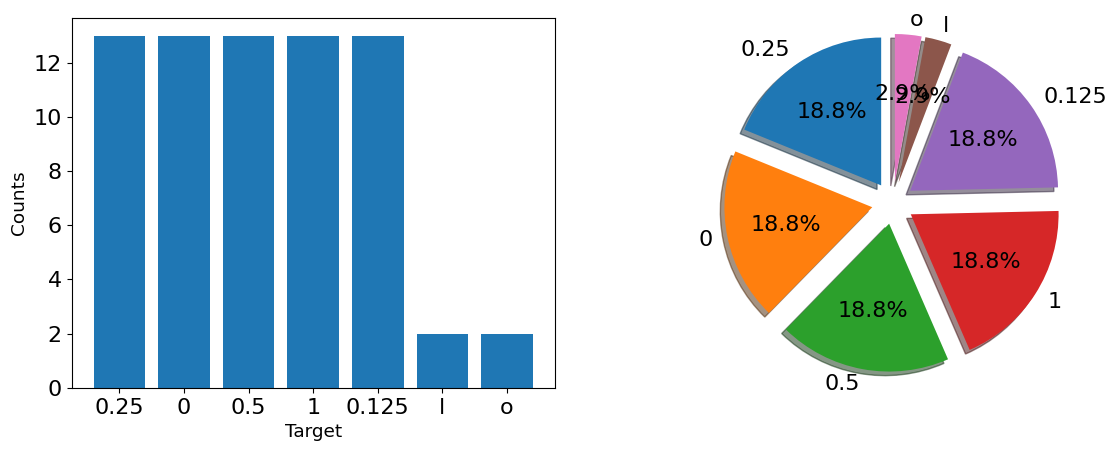

In [690]:
variable_distribution(x=ranked_target_by_user_df['target'], 
                      y=ranked_target_by_user_df['count'])

# **5. Explolatory Data analysis** <a class="anchor" id="5"></a>

[Go back to table of contents](#0.1)

Let first do some chart indicate the top 5 target types as we evaluated above

### Group the target by categrical columns/attributs/variables

In [691]:
# Let quick overview targets by x4
# we have something like this
target_by_x2 = df.groupBy('target', 'x4').count().orderBy("x4", ascending=False).toPandas() 
target_by_x2

,target,x4,count
0,0,y,11
1,0.125,y,5
2,0.25,y,5
3,0.5,y,3
4,1,y,11
...,...,...,...
64,0.25,a,7
65,0.125,a,10
66,0.5,a,11
67,1,a,11


# **6. UNSTACK CATEGORICAL VARIABLES** <a class="anchor" id="5"></a>
[Go back to table of contents](#0.1)

We want reshape the table above to flatten the x4 column so that we can visualize on it. I draw a simple draft as follow 
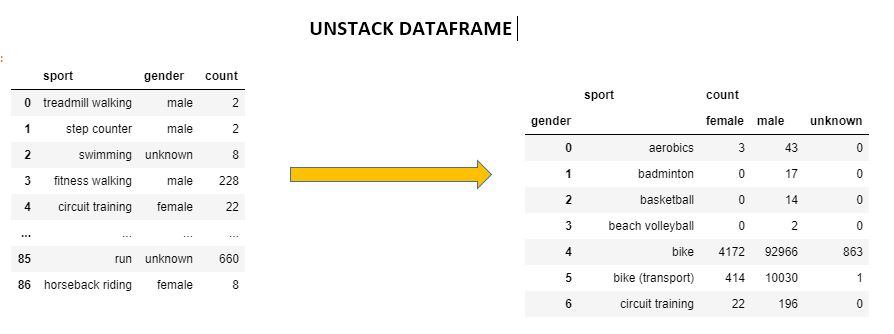

To reshape the table like this in Pyspark, we use 
```python
df.unstack()
```

There are total: 7 targets and here is the chart for targets based on x4:


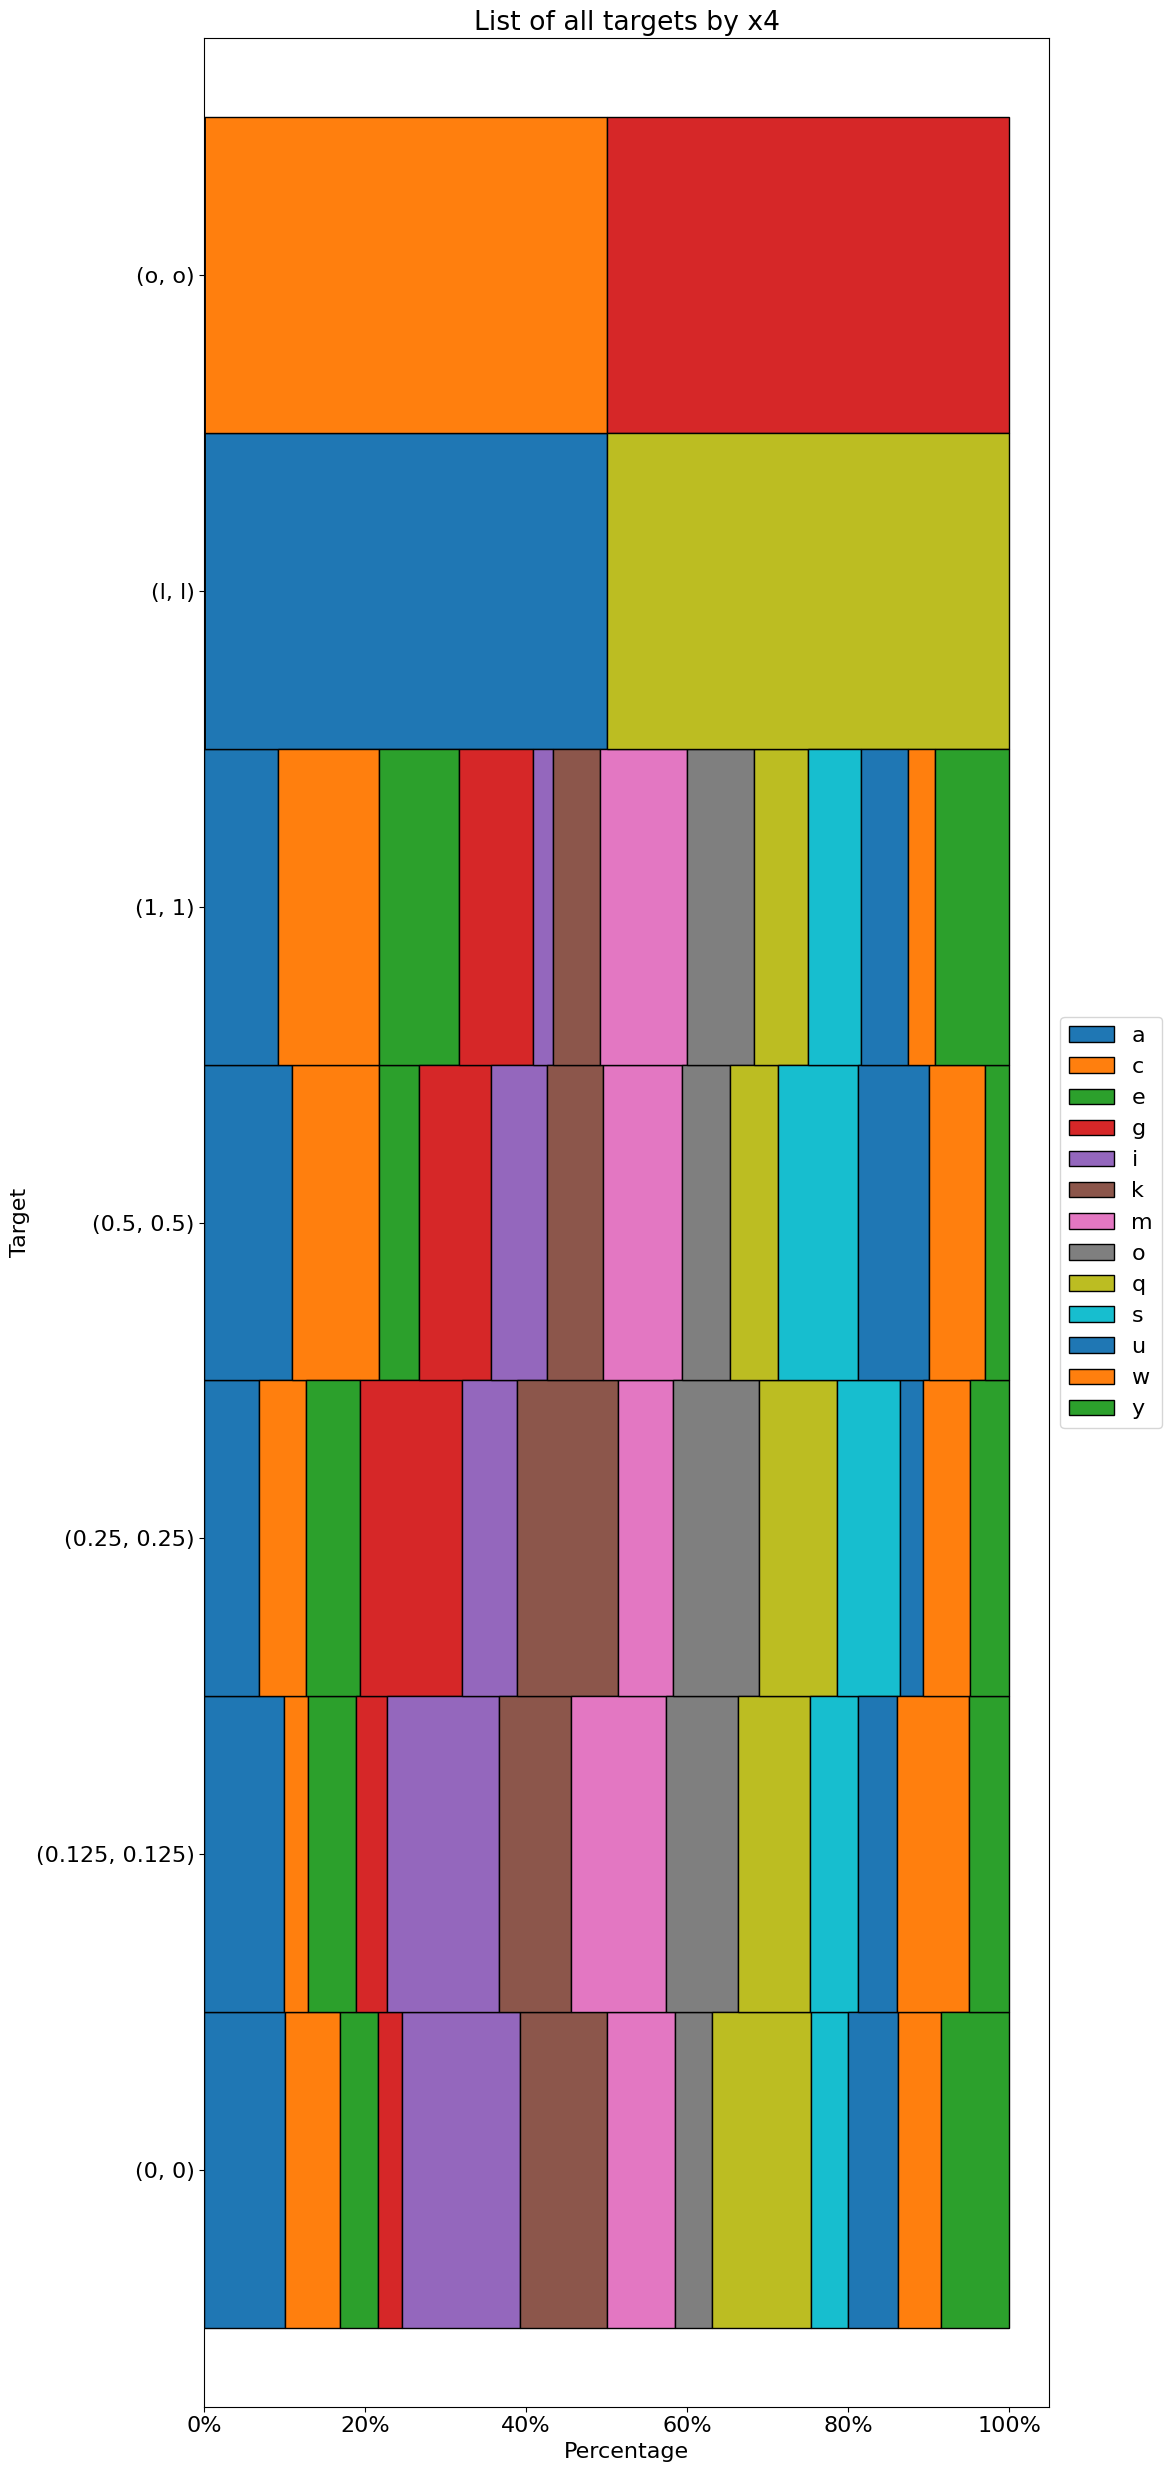

In [692]:
total_targets = ranked_target_by_user.count()
print(f'There are total: {total_targets} targets and here is the chart for targets based on x4:')
# Add the infor of targets based on x4
targets_by_x4 = df.groupBy('target', 'x4').count().toPandas()
# Visualize
fig = plt.figure(figsize=(12, 25))
grid_size = (1,1);
ax = plt.subplot2grid(grid_size, (0,0), colspan=1, rowspan=1)
plot = targets_by_x4.groupby(['target', 'x4']).agg(np.mean).groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='barh', stacked=True, width=1  ## APPLY UNSTACK TO RESHAPE DATA
                , edgecolor='black', ax=ax, title='List of all targets by x4')
ylabel = plt.ylabel('Target');
xlabel = plt.xlabel('Percentage');
legend = plt.legend(
    sorted(targets_by_x4['x4'].unique()), loc='center left', bbox_to_anchor=(1.0, 0.5)
)
param_update = plt.rcParams.update({'font.size': 16});
ax = plt.gca()
formatter = ax.xaxis.set_major_formatter(mtick.PercentFormatter());
a = fig.tight_layout()
plt.show()

The X4 variables seems to be randomly distributed along the target values

In [693]:
targets_by_x4_df = targets_by_x4.pivot_table(
    index="target", columns="x4", values='count', fill_value=0) \
    .reset_index().rename_axis(None, axis=1)
list_categories = list(targets_by_x4_df.drop(columns='target').columns)
targets_by_x4_df['total'] = targets_by_x4_df.drop(columns='target').sum(axis=1)

targets_by_x4_df['percentage'] = targets_by_x4_df['total'] \
    / sum(targets_by_x4_df['total']) * 100
top_targets_by_x4_df = targets_by_x4_df.sort_values(
    by='percentage', ascending=False
).head(5)

# others = {'target' : 'others'}
# for column in list_categories:
#     value = sum(targets_by_x4_df[column]) - sum(top_targets_by_x4_df[column])
#     others.update({column: value})
top_targets_by_x4_df = pd.concat([top_targets_by_x4_df, pd.DataFrame([others])], ignore_index=True)
top_targets_by_x4_df = top_targets_by_x4_df.sort_values(
    by='percentage', ascending=False
)

top_targets_by_x4_df

,target,a,c,e,g,i,k,m,o,q,s,u,w,y,total,percentage
0,0,13,9,6,4,19,14,11,6,16,6,8,7,11,130.0,23.255814
1,1,11,15,12,11,3,7,13,10,8,8,7,4,11,120.0,21.466905
2,0.25,7,6,7,13,7,13,7,11,10,8,3,6,5,103.0,18.425760
3,0.125,10,3,6,4,14,9,12,9,9,6,5,9,5,101.0,18.067979
4,0.5,11,11,5,9,7,7,10,6,6,10,9,7,3,101.0,18.067979
5,others,1,1,0,1,0,0,0,0,1,0,0,0,0,NaN,NaN


In [694]:
top_targets_by_x4_df

,target,a,c,e,g,i,k,m,o,q,s,u,w,y,total,percentage
0,0,13,9,6,4,19,14,11,6,16,6,8,7,11,130.0,23.255814
1,1,11,15,12,11,3,7,13,10,8,8,7,4,11,120.0,21.466905
2,0.25,7,6,7,13,7,13,7,11,10,8,3,6,5,103.0,18.425760
3,0.125,10,3,6,4,14,9,12,9,9,6,5,9,5,101.0,18.067979
4,0.5,11,11,5,9,7,7,10,6,6,10,9,7,3,101.0,18.067979
5,others,1,1,0,1,0,0,0,0,1,0,0,0,0,NaN,NaN


In [695]:
def remove_nan_valued_rows(df:pd.DataFrame) -> pd.DataFrame:
    missing_values = count_missings(df,sort=True)
    if missing_values.max().max()>0:
        # check rows with missing values
        nan_rows = list(df[df.isna().sum(axis=1)>0].index)
        print(f'\n The following {len(nan_rows)} rows will be removed as they have missing/invalid values: \n - {nan_rows}')
        df = df.dropna()
    else:
        print(f'\n The data has no missing/invalid values!')
        
    return df

top_targets_by_x4_df = remove_nan_valued_rows(top_targets_by_x4_df)
top_targets_by_x4_df

24/09/24 20:16:09 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.



 The following 1 rows will be removed as they have missing/invalid values: 
 - [5]


,target,a,c,e,g,i,k,m,o,q,s,u,w,y,total,percentage
0,0,13,9,6,4,19,14,11,6,16,6,8,7,11,130.0,23.255814
1,1,11,15,12,11,3,7,13,10,8,8,7,4,11,120.0,21.466905
2,0.25,7,6,7,13,7,13,7,11,10,8,3,6,5,103.0,18.425760
3,0.125,10,3,6,4,14,9,12,9,9,6,5,9,5,101.0,18.067979
4,0.5,11,11,5,9,7,7,10,6,6,10,9,7,3,101.0,18.067979


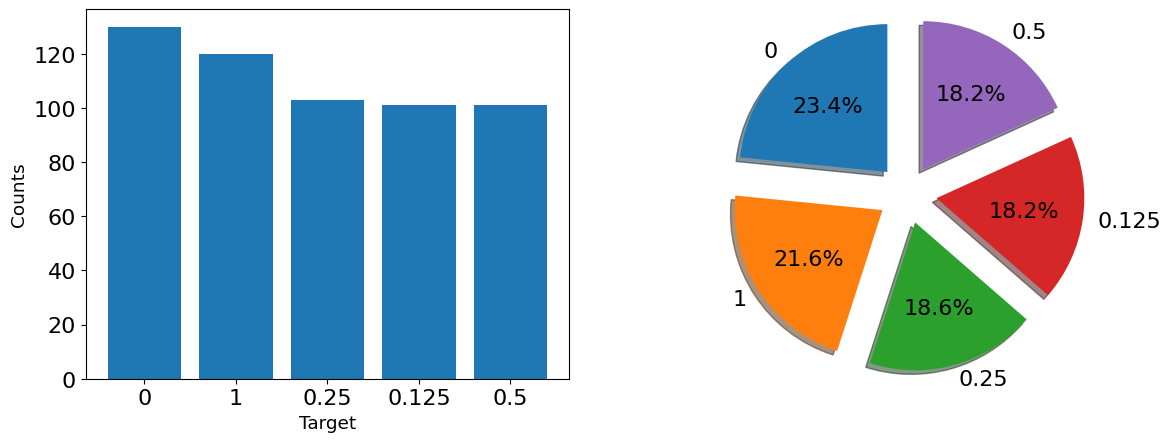

In [696]:

variable_distribution(x=top_targets_by_x4_df['target'], 
                      y=top_targets_by_x4_df['total'])

### Distribution of records count per target


- [cleaned dataset1](size = (555, 10)) 


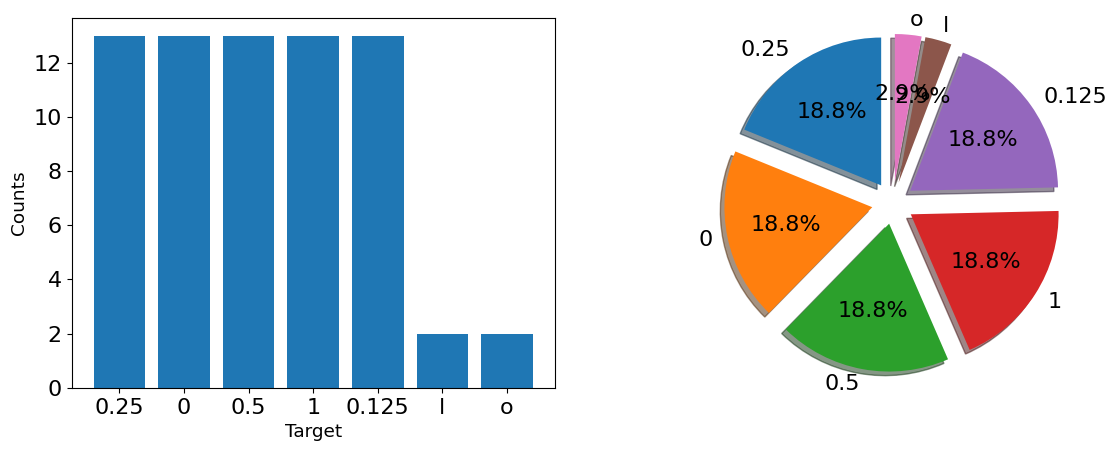

In [852]:
print(f'\n- [cleaned dataset1](size = {(df.count(), len(df.columns))}) ')
variable_distribution(x=ranked_target_by_user_df['target'], 
                      y=ranked_target_by_user_df['count'])

- The 2.0% threshold corresonds to a minimum of 11 samples

- [cleaned dataset2](size = (555, 10)): sample with rare label were remove 


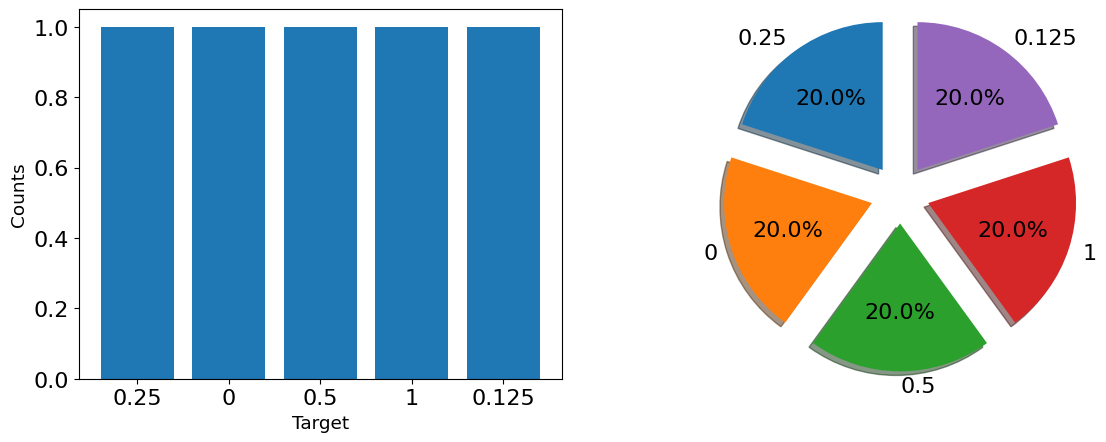

In [853]:
REMOVE_RARE_LABELS = True
MIN_PERCENTAGE = 0.02 # minimal percentage of sample per target label

if REMOVE_RARE_LABELS:
    qualified_df = df \
        .select(df.target, df.x3, df.x4) \
        .groupBy(df.target) \
        .count()
    #  rank the label by count/percentage
    total_samples = qualified_df.select(F.sum(qualified_df['count'])).collect()[0][0]
    samples_threshold = int(MIN_PERCENTAGE*total_samples)
    print(f'- The {100*MIN_PERCENTAGE}% threshold corresonds to a minimum of {samples_threshold} samples')
    qualified_df = qualified_df.filter(qualified_df["count"]>=samples_threshold) \
        .orderBy("count", ascending = False)
    
    # define the list of labels to be remvoed
    label_to_preserve = qualified_df.toPandas()['target'].to_list()
    all_labels = df.select('target').distinct().rdd.map(lambda r: r[0]).collect()
    label_to_remove = list(set(all_labels)-set(label_to_preserve))
    if len(label_to_remove)>0:
        print(f'- The following target label(s) need(s) to be removed : \n{label_to_remove} ')

    # remove the rows from the dataframe
    for label in label_to_remove:
        df = df.filter((df.target != label))
    # display message
    print(f'\n- [cleaned dataset2](size = {(df.count(), len(df.columns))}): sample with rare label were remove ')
        
#  visualize the cleaned dataset 
cleaned_data_count_df = df.select(df.target) \
                    .distinct() \
                    .groupBy(df.target) \
                    .count() \
                    .orderBy("count", ascending=False).toPandas()

variable_distribution(x=cleaned_data_count_df['target'], 
                      y=cleaned_data_count_df['count'])